---
title: "EM-Algorithm for Probabilistic Modeling"
date: 2025-04-09
last_modified_at: 2025-04-09
categories:
  - Note
tags:
  - Probabilistic Modeling
  - Machine Leanring
---
This is just a note for myself about the EM algorithm for the upcoming exam, therefore so no spelling check or polishing, if you find any mistake beside spelling, please fill free to point out.

So the basic idea of EM algorithm is that if we observe some data, but some information of the data is missing or we can not observe, then EM can be used to estimate those missing information, as for its name, EM:
- E step: Estimate the the likelihood of the data with our guess of the missing information.
- M step: Tune the paramters to result the maximum likelihood.


One most direct example is that if we have data $X=\{x_1,x_2,.....x_n\}$ which comes from a two component Gaussian mixture model as:
$$
p(x_n|\tau,\theta)=(1-\tau)\mathcal{N}(x_n|0,1)+\tau\mathcal{N}(x_n|\theta,1).
$$
Which there are many ways to interprete this equation, from the persepective of probabilistic, we can see it as when given a $x_n$, it has $1-\tau$ probability that is comes from the distribution $\mathcal{N}(0,1)$ and probability of $\tau$ from $\mathcal{N}(\theta,1)$. But assume that if we do not no the $\tau$ and $\theta$, how do we classify and determine which distirbutino they are from? Then EM will be the way. We can first generate the data as below with ground truth $\tau$ and $\theta$:

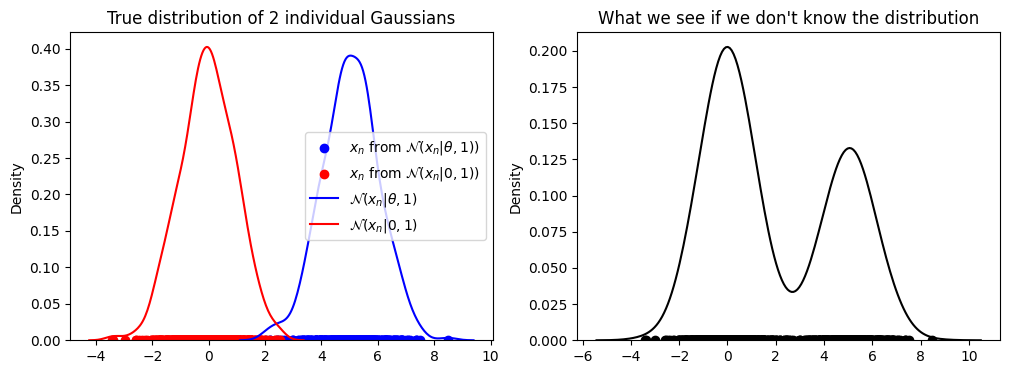

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n=1000
tau=0.4
theta=5
taus=np.random.rand(n) <= tau 
X=np.zeros(n)
X[taus]=np.random.normal(theta,1,size=np.sum(taus))
X[~taus]=np.random.normal(0,1,size=n-np.sum(taus))
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(X[taus],np.zeros(np.sum(taus)), color='blue', label=r'$x_n$ from $\mathcal{N}(x_n|\theta,1)$)')
plt.scatter(X[~taus],np.zeros(n-np.sum(taus)), color='red', label=r'$x_n$ from $\mathcal{N}(x_n|0,1)$)')
sns.kdeplot(X[taus], label=r'$\mathcal{N}(x_n|\theta,1)$', color='blue', fill=False)
sns.kdeplot(X[~taus], label=r'$\mathcal{N}(x_n|0,1)$', color='red', fill=False)
plt.title("True distribution of 2 individual Gaussians")
plt.legend()
plt.subplot(1,2,2)
sns.kdeplot(X, color='black', fill=False)
plt.scatter(X,np.zeros(n), color='black')
plt.title("What we see if we don't know the distribution")
plt.show()


From the data we generate, if we do not no the $\tau$ and $\theta$, we only observe the plot on the right, which with given a data point, we do not know the possibility of which Guassian it came from. 

So now we can perform EM to estimate the $\tau$ and $\theta$. So first, we will need the complete data log-likelihood. We will first assume that there are a hidden variable that indicates which distribution the data is generate from as $z_n$. So if $z_n=1$ the data is from $\mathcal{N}(\theta,1)$ and if $z_n=0$ the data is from $\mathcal{N}(0,1)$, so we can write the complete data likelihood as:
$$
p(x_n,z_n|\tau,\theta)=\left((1-\tau)\mathcal{N}(x_n|0,1)\right)^{1-z_n}\left(\tau\mathcal{N}(x_n|\theta,1)\right)^{z_n}
$$
which allows us to model the responsibality of the 2 distributions separately for each data points instead of a gloabl probability $\tau$ for every data points. Then the entire dataset likelihood can be written as:
$$
p(X,Z|\theta,\tau)=\prod_{i=1}^N(1-\tau)^{1-z_n}\mathcal{N}(x_n|0,1)^{1-z_n}\tau^{z_n}\mathcal{N}(x_n|\theta,1)^{z_n}\\
\text{taking the log}\\
\log p(X,Z|\theta,\tau)=\sum_{n=1}^{N}\left[z_n\log\tau+(1-z_n)\log(1-\tau)-\frac{1}{2}z_n(x_n-\theta)^2-\frac{1}{2}(1 - z_n)(x_n-0)^2-\frac{1}{2}\log(2\pi)\right].
$$

Then we can start the E step, but just to give the big picture, we want to find $\tau$ and $\theta$ that maximize the likelihodd. So first with given the current $\tau$ and $\theta$ which is the initialed values or values from the previous iteration, we need $z_n$, which is the posterior of $z_n$ given other observation as:
$$
p(z_n=1|x_n,\theta^{(0)},\tau^{(0)})
$$
so given $\tau$ and $\theta$ what is the probabilty of $z_n=1$ (or the expected value of $z_n=1$), with Bayes' rule, we can get:
$$
\frac{\tau^{(0)}\mathcal{N}(x_n|\theta^{(0)},1)}{\tau^{(0)}\mathcal{N}(x_n|\theta^{(0)},1)+(1-\tau^{(0)})\mathcal{N}(x_n|0^{(0)},1)}
$$
and we set this to be $\gamma_{n1}$ and since $z_n$ is a Binomial distribution, then $\gamma_{n2}=1-\gamma_{n1}$. Then with the value of $z_n$, we can get the estimated log-likelihood with the current parameters:
$$
Q(\tau,\theta|\tau^{(0)}\theta^{(0)})=\sum_{n=1}^{N}\left[\gamma_n\log\tau+(1-\gamma_{n1})\log(1-\tau)-\frac{1}{2}\gamma_n(x_n-\theta)^2-\frac{1}{2}(1 -\gamma_{n1})x_n^2-\frac{1}{2}\log(2\pi)\right].
$$

With the E step finished, next is to find the $\tau$ and $\theta$ that maximize it, which is simple by calculating the derivative of the Q function regarding to $\tau$ and $\theta$ respectively and solve for them by setting it equal to 0, as:
$$
\text{Updating with regard }\theta:\\
\frac{\partial}{\partial\theta}Q(\theta,\tau)=0\Rightarrow \frac{\partial}{\partial\theta}\left[ - \sum_{n=1}^{N} \gamma_n (x_n - \theta)^2 \right]=\sum_{n=1}^{N} \gamma_n (x_n - \theta)\\
\sum_{n=1}^{N} \gamma_n (x_n - \theta)=0\Rightarrow \theta=\frac{\sum_{n=1}^{N} \gamma_n x_n}{\sum_{n=1}^{N} \gamma_n}\\
\text{Updating with regard }\tau:\\
\frac{\partial}{\partial\tau}Q(\theta,\tau)=0\Rightarrow \frac{\partial}{\partial\tau}\sum_{n=1}^{N} \left[ \gamma_n \log \tau + (1 - \gamma_n) \log (1 - \tau) \right]=\sum_{n=1}^{N}\left[\gamma_n\frac{1}{\tau}-(1-\gamma_n)\frac{1}{1-\tau}\right]\\
\sum_{n=1}^{N}\left[\gamma_n\frac{1}{\tau}-(1-\gamma_n)\frac{1}{1-\tau}\right]=0 \Rightarrow \tau=\frac{1}{N}\sum_{n=1}^{N}\gamma_n.
$$
Then we can repeate the process untill converges.

Final estimates: theta=5.0587051345568765, tau=0.3907281013239721


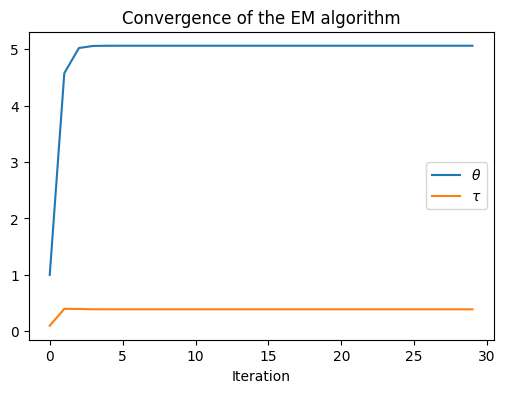

In [45]:
import scipy.stats
n_iter=30
thetas=np.zeros(n_iter)
taus=np.zeros(n_iter)
# Initial guesses for theta and tau
thetas[0] = 1
taus[0] = 0.1
for it in range(1, n_iter):
    # The current estimates for theta and tau,
    # computed in the previous iteration
    theta_0 = thetas[it-1]
    tau_0 = taus[it-1]
    # E-step
    r1=taus[it-1]*scipy.stats.norm.pdf(X, thetas[it-1], 1)/(taus[it-1]*scipy.stats.norm.pdf(X, thetas[it-1], 1)+(1-taus[it-1])*scipy.stats.norm.pdf(X, 0, 1))
    r2=1-r1
    # M-step
    thetas[it] = np.sum(r1 * X) / np.sum(r1)
    taus[it] = np.mean(r1)
print(f"Final estimates: theta={thetas[-1]}, tau={taus[-1]}")
plt.figure(figsize=(6, 4))
plt.plot(thetas, label=r'$\theta$')
plt.plot(taus, label=r'$\tau$')
plt.title("Convergence of the EM algorithm")
plt.xlabel("Iteration")
plt.legend()
plt.show()

Then from the code above performing EM algorithm, we can see that we eventually result in an estimation of $\tau$ and $\theta$ close to the ground truth. 

So this note briefly goes through the intuition of EM algorithm and quick example and derivation of a Guassian mixture model, and again this note is basically for my personal need, so no spelling check or polishing.